In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import DisplayObject
%pylab inline
import os
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
# deal with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import PIL
from PIL import Image
from IPython.display import display
import csv
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

Populating the interactive namespace from numpy and matplotlib


# Data Prep
- From the initial training images, put ~70% into training and 30% into validation

# EDA

In [7]:
number_of_classes = 3

In [8]:
rootdir = '../kaggle - Cervical Cancer Screening/data/train'
train_images_pd = pd.DataFrame()
all_train_images = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        full_path = os.path.join(subdir, file)
        all_train_images.append(full_path)
train_images_pd['image_path']=all_train_images
train_images_pd['type'] = [ x.split('/')[-2] for x in all_train_images] 
all_train_images.remove('../kaggle - Cervical Cancer Screening/data/train/.DS_Store')

In [9]:
train_images_pd .head()

image_path    type
0  ../kaggle - Cervical Cancer Screening/data/tra...   train
1  ../kaggle - Cervical Cancer Screening/data/tra...  type_1
2  ../kaggle - Cervical Cancer Screening/data/tra...  type_1
3  ../kaggle - Cervical Cancer Screening/data/tra...  type_1
4  ../kaggle - Cervical Cancer Screening/data/tra...  type_1

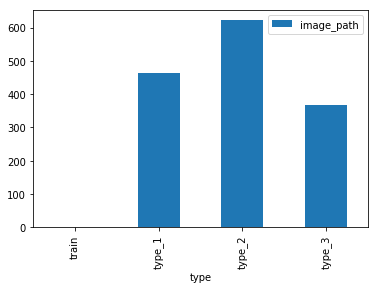

In [10]:
train_images_pd.groupby('type').count().plot(kind='bar')

In [6]:
print('Total of {} images'.format(train_images_pd.shape[0]))

Total of 1256 images


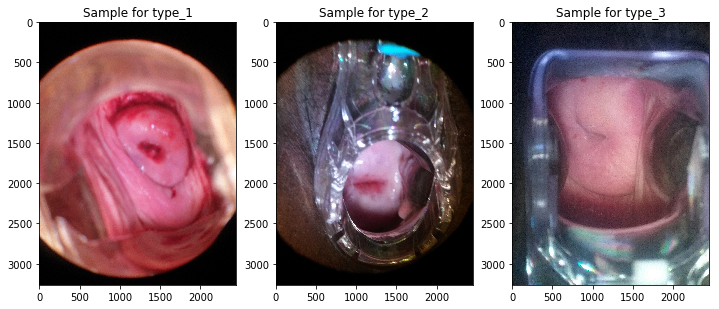

In [64]:
i = 1
fig = plt.figure(figsize=(12,8))
for t in ['type_1','type_2','type_3']:
    ax = fig.add_subplot(1,3,i)
    plt.title('Sample for {}'.format(t))
    i+=1
    f = train_images_pd[train_images_pd.type == t].iloc[0,:]['image_path']
    plt.imshow(plt.imread(f))

# Next, look at image dimensions

In [95]:
[plt.imread(train_images_pd[train_images_pd.type=='type_1'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[(4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3),
 (4128, 3096, 3)]

In [94]:
[plt.imread(train_images_pd[train_images_pd.type=='type_2'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

[(3264, 2448, 3),
 (3264, 2448, 3),
 (4128, 3096, 3),
 (4128, 2322, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (4128, 3096, 3)]

In [96]:
[plt.imread(train_images_pd[train_images_pd.type=='type_3'].iloc[i,:]['image_path']).shape for i in range(1,15,2)]

[(4128, 3096, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (4128, 3096, 3),
 (3264, 2448, 3),
 (3264, 2448, 3),
 (3264, 2448, 3)]

# Set up data generator

In [41]:
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [326]:
train_datagen = ImageDataGenerator(
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                    vertical_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=[224, 224],
                                                    batch_size=16,
                                                   classes=['type_1','type_2','type_3'])

Found 1000 images belonging to 3 classes.


In [327]:
validation_datagen = ImageDataGenerator(
                                   rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                    vertical_flip=True,
                                   fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(directory='data/validation/',
                                                              target_size=[224, 224],
                                                              batch_size=16,
                                                             classes=['type_1','type_2','type_3'])

Found 481 images belonging to 3 classes.


### Examine some images after the data augmentation

In [301]:
x_train_augment, y_train_augment = next(train_generator)

In [303]:
x_train_augment.shape

(16, 224, 224, 3)

In [331]:
y_train_augment.shape

(16, 3)

# Test logistic regression model

In [336]:
model = Sequential()

In [337]:
model.add(Flatten(batch_input_shape=(None,224,224,3)))
model.add(Dense(3,activation='softmax'))


In [338]:
model.compile(optimizer='adam',metrics=['accuracy'], loss='categorical_crossentropy')

In [339]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 451587    
Total params: 451,587.0
Trainable params: 451,587.0
Non-trainable params: 0.0
_________________________________________________________________


In [340]:
loss = model.fit_generator(train_generator, steps_per_epoch=16, 
                    epochs=10, verbose=1, validation_data=validation_generator, validation_steps=16)

Epoch 1/10


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

 4/16 [======>.......................] - ETA: 176s - loss: 8.3109 - acc: 0.4844

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 520880128 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11090. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21488365096 bytes but only got 0. Skipping tag 40486
  "Skipping tag %s" % (size, len(data), tag))


 5/16 [========>.....................] - ETA: 152s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204996608 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205520896 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507248640 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10884. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/16 [============>.................] - ETA: 128s - loss: 10.3616 - acc: 0.3571

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587857920 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12112. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 451346432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10029. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 9/16 [===============>..............] - ETA: 98s - loss: 9.7380 - acc: 0.3958  

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 465633280 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10247. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 460455936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10168. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

10/16 [=================>............] - ETA: 83s - loss: 9.7716 - acc: 0.3937

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 431554560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


11/16 [===================>..........] - ETA: 67s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 759824384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14936. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 620036096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12603. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

12/16 [=====================>........] - ETA: 52s - loss: 9.8220 - acc: 0.3906 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 609681408 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12645. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 548274176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

13/16 [=======================>......] - ETA: 38s - loss: 9.7638 - acc: 0.3942

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 878444544 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 16746. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 727973888 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14450. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/16 [=========================>....] - ETA: 25s - loss: 9.8579 - acc: 0.3884

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 570097664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11841. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


15/16 [===========================>..] - ETA: 12s - loss: 10.1410 - acc: 0.3708

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 692191232 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13904. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20791909992 bytes but only got 0. Skipping tag 39940
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 480182272 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), 

16/16 [==============================] - 422s - loss: 10.3257 - acc: 0.3594 - val_loss: 10.6405 - val_acc: 0.3398
Epoch 2/10
11/16 [===================>..........] - ETA: 4s - loss: 11.1728 - acc: 0.3068

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 697106432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13979. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 641466368 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12930. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

13/16 [=======================>......] - ETA: 6s - loss: 11.6236 - acc: 0.2788

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 461438976 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10383. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


14/16 [=========================>....] - ETA: 5s - loss: 11.4410 - acc: 0.2902

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 644612096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12978. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


15/16 [===========================>..] - ETA: 3s - loss: 11.4841 - acc: 0.2875

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 571146240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11857. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 632815616 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12798. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

16/16 [==============================] - 215s - loss: 11.2071 - acc: 0.3047 - val_loss: 12.2391 - val_acc: 0.2407
Epoch 3/10
12/16 [=====================>........] - ETA: 6s - loss: 11.0812 - acc: 0.3125

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13441. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482148352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10499. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/16 [=========================>....] - ETA: 5s - loss: 10.7214 - acc: 0.3348

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 479068160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


15/16 [===========================>..] - ETA: 2s - loss: 10.6782 - acc: 0.3375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600899584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521732096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11103. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

16/16 [==============================] - 223s - loss: 10.7664 - acc: 0.3320 - val_loss: 11.4590 - val_acc: 0.2891
Epoch 4/10
10/16 [=================>............] - ETA: 0s - loss: 10.8797 - acc: 0.3250

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531496960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8939330528 bytes but only got 0. Skipping tag 38038
  "Skipping tag %s" % (size, len(data), tag))


11/16 [===================>..........] - ETA: 4s - loss: 10.7149 - acc: 0.3352

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587464704 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12106. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1839658997 bytes but only got 0. Skipping tag 28034
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 631046144 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

15/16 [===========================>..] - ETA: 3s - loss: 10.1410 - acc: 0.3708

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 470548480 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10522. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 210s - loss: 10.2076 - acc: 0.3667 - val_loss: 11.1021 - val_acc: 0.3112
Epoch 5/10
15/16 [===========================>..] - ETA: 2s - loss: 11.0140 - acc: 0.3167

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 775159808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14970. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 211s - loss: 11.0182 - acc: 0.3164 - val_loss: 11.2071 - val_acc: 0.3047
Epoch 6/10
15/16 [===========================>..] - ETA: 2s - loss: 11.3498 - acc: 0.2958

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640811008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12920. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 195s - loss: 11.3960 - acc: 0.2930 - val_loss: 11.8378 - val_acc: 0.2656
Epoch 7/10
15/16 [===========================>..] - ETA: 2s - loss: 11.4170 - acc: 0.2917

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 581763072 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12019. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 201s - loss: 11.3330 - acc: 0.2969 - val_loss: 11.3960 - val_acc: 0.2930
Epoch 8/10
16/16 [==============================] - 198s - loss: 11.3909 - acc: 0.2933 - val_loss: 11.8378 - val_acc: 0.2656
Epoch 9/10
16/16 [

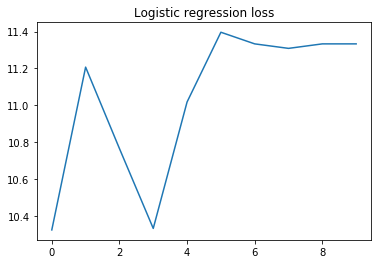

In [344]:
plt.title('Logistic regression loss')
plt.plot(loss.history['loss'])


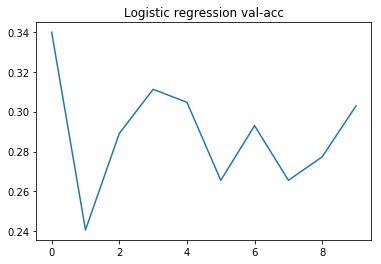

In [347]:
plt.title('Logistic regression val-acc')
plt.plot(loss.history['val_acc'])


#### Only ~ 30% accuracy with logsitic regression. About the same as random guessing.

# Test VGG16 for transfer learning
- First, test out of the box predictions

In [45]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Replace the last layer with only three classes

In [46]:
fc2 = vgg16.get_layer('fc2').output
p = Dense(output_dim=3, activation='softmax', name='logit')(fc2)
model = Model(input=vgg16.input, output=p)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="logit", units=3)`
  
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [351]:
X_val_sample, y_actual = next(validation_generator)
y_pred = model.predict(X_val_sample)






/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

In [352]:
y_actual[:]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]], dtype=float32)

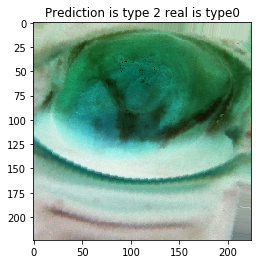

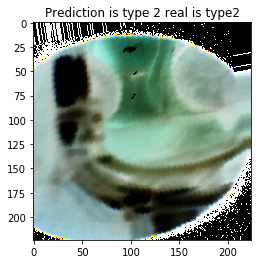

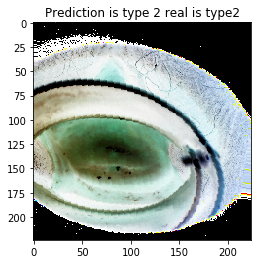

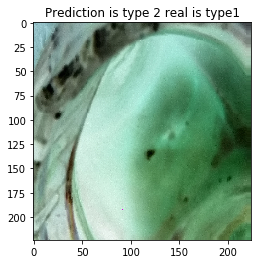

In [353]:
nb_sample = 4
for x, y,z in zip(X_val_sample[:nb_sample], y_pred[:nb_sample],y_actual[:nb_sample,:]):
    plt.figure()
    plt.imshow(x)

    plt.title('Prediction is type {} real is type{}'.format(np.argmax(y),np.argmax(z)))

# Test training just the bottleneck features

In [47]:
model_bottleneck = model

In [48]:
model_bottleneck.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

In [54]:
for k,v in model_bottleneck.layers_by_depth.items():
    print(k,v[0].trainable,v)
    if k < 3:
        pass
    else:
        v[0].trainable = False

0 True [<keras.layers.core.Dense object at 0x126a7aba8>]
1 True [<keras.layers.core.Dense object at 0x1380b89b0>]
2 True [<keras.layers.core.Dense object at 0x13808fbe0>]
3 False [<keras.layers.core.Flatten object at 0x138072160>]
4 False [<keras.layers.pooling.MaxPooling2D object at 0x138057518>]
5 False [<keras.layers.convolutional.Conv2D object at 0x12f8efd30>]
6 False [<keras.layers.convolutional.Conv2D object at 0x12f8e3cf8>]
7 False [<keras.layers.convolutional.Conv2D object at 0x12f8abc88>]
8 False [<keras.layers.pooling.MaxPooling2D object at 0x12f88de80>]
9 False [<keras.layers.convolutional.Conv2D object at 0x12f854e48>]
10 False [<keras.layers.convolutional.Conv2D object at 0x1274f3f98>]
11 False [<keras.layers.convolutional.Conv2D object at 0x1274ff2b0>]
12 False [<keras.layers.pooling.MaxPooling2D object at 0x1274e53c8>]
13 False [<keras.layers.convolutional.Conv2D object at 0x12737fbe0>]
14 False [<keras.layers.convolutional.Conv2D object at 0x12711f668>]
15 False [<keras

In [51]:
bottleneck_history = [] 
model_bottleneck.load_weights('weights/model_bottleneck.h5')
try:
    loss = model_bottleneck.fit_generator(train_generator,
                        steps_per_epoch=16,
                        epochs=15,
                        validation_data=validation_generator,
                        validation_steps=15);
    bottleneck_history.append(loss)
except:
    pass

# serialize model to YAML
model_yaml_bottleneck = model_bottleneck.to_yaml()
with open("weights/model_bottleneck.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml_bottleneck)
# serialize weights to HDF5
model_bottleneck.save_weights("weights/model_bottleneck.h5")

Epoch 1/5


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

 1/32 [..............................] - ETA: 2541s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 632815616 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12798. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 456523776 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10108. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 2/32 [>.............................] - ETA: 2156s - loss: 9.0664 - acc: 0.4375 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452067328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10240. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 570097664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11841. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 3/32 [=>............................] - ETA: 1966s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 641466368 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12930. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 5/32 [===>..........................] - ETA: 1664s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482344960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10502. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 490602496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 6/32 [====>.........................] - ETA: 1558s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 431554560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/32 [=====>........................] - ETA: 1464s - loss: 6.9078 - acc: 0.5714

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 438370304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9831. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 8/32 [======>.......................] - ETA: 1383s - loss: 6.9257 - acc: 0.5703

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 617021440 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12757. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615251968 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12530. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 9/32 [=======>......................] - ETA: 1303s - loss: 7.1636 - acc: 0.5556

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 548274176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6694150584 bytes but only got 0. Skipping tag 19019
  "Skipping tag %s" % (size, len(data), tag))


11/32 [=========>....................] - ETA: 1166s - loss: 7.4180 - acc: 0.5398

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 621150208 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12620. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 597819392 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12264. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

12/32 [==========>...................] - ETA: 1105s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600309760 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12302. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/32 [===========>..................] - ETA: 1044s - loss: 7.5941 - acc: 0.5288

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482738176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521732096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11103. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/32 [============>.................] - ETA: 983s - loss: 7.5554 - acc: 0.5312 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 697368576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13983. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1411602240 bytes but only got 0. Skipping tag 42982
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 446365696 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

15/32 [=============>................] - ETA: 923s - loss: 7.3875 - acc: 0.5417

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600113152 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482148352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10499. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

17/32 [==============>...............] - ETA: 807s - loss: 7.5257 - acc: 0.5331

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 898760704 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16856. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


18/32 [===============>..............] - ETA: 750s - loss: 7.5554 - acc: 0.5312

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521994240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11107. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 554041344 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11596. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

19/32 [================>.............] - ETA: 694s - loss: 7.6349 - acc: 0.5263

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 573112320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 701890560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14052. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

20/32 [=================>............] - ETA: 638s - loss: 7.7065 - acc: 0.5219

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 470548480 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10522. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


21/32 [==================>...........] - ETA: 583s - loss: 7.5793 - acc: 0.5298

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600899584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


22/32 [===================>..........] - ETA: 529s - loss: 7.5096 - acc: 0.5341

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 650903552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13274. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


23/32 [====================>.........] - ETA: 475s - loss: 7.4021 - acc: 0.5408

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640024576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12908. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 567083008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11795. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

25/32 [======================>.......] - ETA: 368s - loss: 7.1726 - acc: 0.5550

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 480182272 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10471. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 692191232 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13904. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

26/32 [=======================>......] - ETA: 314s - loss: 7.2454 - acc: 0.5505

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 494862336 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10693. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507576320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

27/32 [========================>.....] - ETA: 261s - loss: 7.2382 - acc: 0.5509

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 520880128 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11090. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21488365096 bytes but only got 0. Skipping tag 40486
  "Skipping tag %s" % (size, len(data), tag))


29/32 [==========================>...] - ETA: 156s - loss: 7.3643 - acc: 0.5431

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537722880 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11347. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425066496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

30/32 [===========================>..] - ETA: 104s - loss: 7.3875 - acc: 0.5417

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 631046144 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12771. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


31/32 [============================>.] - ETA: 51s - loss: 7.4741 - acc: 0.5363 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 512098304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10956. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5613949592 bytes but only got 0. Skipping tag 19083
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 628752384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

32/32 [==============================] - 2205s - loss: 7.6183 - acc: 0.5273 - val_loss: 7.0699 - val_acc: 0.5614
Epoch 2/5


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 476315648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10410. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 488898560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10602. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 1/32 [..............................] - ETA: 1563s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507248640 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10884. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 2/32 [>.............................] - ETA: 1490s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 644612096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12978. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587792384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 3/32 [=>............................] - ETA: 1436s - loss: 8.7306 - acc: 0.4583 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 487981056 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10588. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 4/32 [==>...........................] - ETA: 1401s - loss: 8.8146 - acc: 0.4531

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587857920 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12112. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 451346432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10029. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 5/32 [===>..........................] - ETA: 1440s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 665649152 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 6/32 [====>.........................] - ETA: 1384s - loss: 8.5627 - acc: 0.4688

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539820032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11379. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/32 [=====>........................] - ETA: 1321s - loss: 8.6347 - acc: 0.4643

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587464704 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12106. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1839658997 bytes but only got 0. Skipping tag 28034
  "Skipping tag %s" % (size, len(data), tag))


10/32 [========>.....................] - ETA: 1230s - loss: 8.3613 - acc: 0.4813

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 798556160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 15327. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 765788160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14827. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

11/32 [=========>....................] - ETA: 1196s - loss: 8.7917 - acc: 0.4545

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587005952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


12/32 [==========>...................] - ETA: 1171s - loss: 8.4788 - acc: 0.4740

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559677440 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11682. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/32 [===========>..................] - ETA: 1130s - loss: 8.4465 - acc: 0.4760

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 707657728 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13940. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640811008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12920. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

15/32 [=============>................] - ETA: 1027s - loss: 8.3277 - acc: 0.4833

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 479068160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/32 [==============>...............] - ETA: 977s - loss: 8.1850 - acc: 0.4922 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 775159808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14970. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


17/32 [==============>...............] - ETA: 923s - loss: 8.1776 - acc: 0.4926

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 545652736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11468. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


18/32 [===============>..............] - ETA: 868s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 727973888 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14450. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13441. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

19/32 [================>.............] - ETA: 812s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 624295936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12668. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531496960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

32/32 [==============================] - 2766s - loss: 8.0876 - acc: 0.4982 - val_loss: 7.1023 - val_acc: 0.5594

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 439287808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 9847. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


22/32 [===================>..........] - ETA: 727s - loss: 8.1048 - acc: 0.4972 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 878444544 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 16746. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


23/32 [====================>.........] - ETA: 656s - loss: 8.2342 - acc: 0.4891

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 846528512 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16059. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26073062320 bytes but only got 0. Skipping tag 50256
  "Skipping tag %s" % (size, len(data), tag))


32/32 [==============================] - 3114s - loss: 8.1535 - acc: 0.4941 - val_loss: 6.7780 - val_acc: 0.5795
Epoch 4/5
32/32 [==============================] - 2858s - loss: 7.8357 - acc: 0.5139 - val_loss: 7.0050 - val_acc: 0.5654

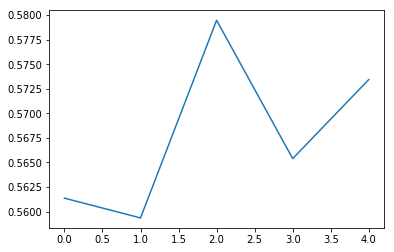

In [59]:
plt.plot(loss.history['val_acc'])

# Test the bottleneck features

In [64]:
rootdir = '../kaggle - Cervical Cancer Screening/data/test'
test_images_pd = pd.DataFrame()
all_test_images = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        full_path = os.path.join(subdir, file)
        all_test_images.append(full_path)

In [116]:
all_test_images[i].split('/')[-1]

'0.jpg'

In [151]:
row = []
with open('bottleneck_predictions.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['image_name','Type_1','Type_2','Type_3'])
    for image in all_test_images:
        name = image.split('/')[-1]

        img = Image.open(image)
        img = img.resize((224,224), PIL.Image.ANTIALIAS)
        img = np.array(img).reshape(1,224,224,3)
        prediction = model_bottleneck.predict(img)
        print(prediction)
        spamwriter.writerow([name,prediction[0][0],prediction[0][1],prediction[0][2]])

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 611057664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12666. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 680591360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559480832 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11879. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204865536 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205389824 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 558563328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11665. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 594411520 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12212. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 750845952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14799. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 497156096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10928. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 716505088 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14275. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499122176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10758. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 565903360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11777. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 668860416 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13548. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 566886400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11792. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 654901248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 513671168 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10980. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 671154176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13583. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 542310400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11417. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 896663552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16824. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 457703424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10126. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 467402752 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10474. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 471859200 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10342. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 627507200 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12917. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25880427512 bytes but only got 0. Skipping tag 20602
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178651468 bytes but only got 0. Skipping tag 20656
  "Skipping tag %s" % (size, len(dat

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 454950912 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10284. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 715718656 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14263. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499187712 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10759. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 527171584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11186. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 518914048 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11060. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 653459456 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13113. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 541589504 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11406. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 510197760 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10927. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 760020992 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14739. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 372937384 bytes but only got 0. Skipping tag 39948
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 445775872 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9944. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 592576512 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12184. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 458293248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615579648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12535. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 550502400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11542. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 411828224 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9426. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 572391424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11876. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 670171136 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13568. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 599064576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12283. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539426816 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11373. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 602996736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12343. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 421462016 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9573. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531562496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11253. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 622264320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12637. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204996608 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205520896 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 670892032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 13381. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 605028352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12374. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452460544 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10046. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 647168000 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13017. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 518586368 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11055. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26527738112 bytes but only got 0. Skipping tag 19153
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537329664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11341. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 532021248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11260. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 592379904 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12181. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


# Try training the last   CNN layers and the bottleneck layer


In [156]:
model_bottleneck_last_cnn = model_bottleneck

In [157]:
model_bottleneck_last_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [349]:
for k,v in model_bottleneck_last_cnn.layers_by_depth.items():
    
    if k < 8:
        v[0].trainable = True
    else:
        v[0].trainable = False
    print(k,v[0].trainable,v)

0 True [<keras.layers.core.Dense object at 0x126a7aba8>]
1 True [<keras.layers.core.Dense object at 0x1380b89b0>]
2 True [<keras.layers.core.Dense object at 0x13808fbe0>]
3 True [<keras.layers.core.Flatten object at 0x138072160>]
4 True [<keras.layers.pooling.MaxPooling2D object at 0x138057518>]
5 True [<keras.layers.convolutional.Conv2D object at 0x12f8efd30>]
6 True [<keras.layers.convolutional.Conv2D object at 0x12f8e3cf8>]
7 True [<keras.layers.convolutional.Conv2D object at 0x12f8abc88>]
8 False [<keras.layers.pooling.MaxPooling2D object at 0x12f88de80>]
9 False [<keras.layers.convolutional.Conv2D object at 0x12f854e48>]
10 False [<keras.layers.convolutional.Conv2D object at 0x1274f3f98>]
11 False [<keras.layers.convolutional.Conv2D object at 0x1274ff2b0>]
12 False [<keras.layers.pooling.MaxPooling2D object at 0x1274e53c8>]
13 False [<keras.layers.convolutional.Conv2D object at 0x12737fbe0>]
14 False [<keras.layers.convolutional.Conv2D object at 0x12711f668>]
15 False [<keras.laye

In [169]:
model_bottleneck_last_cnn.load_weights('weights/model_bottleneck.h5')

loss = model_bottleneck_last_cnn.fit_generator(train_generator,
                        steps_per_epoch=16,
                        epochs=30,
                        validation_data=validation_generator,
                        validation_steps=16);

# serialize model to YAML
model_yaml_bottleneck = model_bottleneck.to_yaml()
with open("weights/model_bottleneck_last_cnn.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml_bottleneck)
# serialize weights to HDF5
model_bottleneck.save_weights("weights/model_bottleneck_last_cnn.h5")

Epoch 1/30


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

 1/16 [>.............................] - ETA: 1147s - loss: 11.0812 - acc: 0.3125

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 196608 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 479068160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10452. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521994240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Us

 2/16 [==>...........................] - ETA: 966s - loss: 9.0664 - acc: 0.4375  

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 548274176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6694150584 bytes but only got 0. Skipping tag 19019
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 759824384 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

 3/16 [====>.........................] - ETA: 861s - loss: 8.7306 - acc: 0.4583

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 853671936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 16368. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 488898560 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10602. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 4/16 [======>.......................] - ETA: 768s - loss: 8.3109 - acc: 0.4844

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 621150208 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12620. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 6/16 [==========>...................] - ETA: 606s - loss: 8.2269 - acc: 0.4896

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 632815616 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12798. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537722880 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11347. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 8/16 [==============>...............] - ETA: 471s - loss: 8.6887 - acc: 0.4609

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 554041344 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11596. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1351410386 bytes but only got 0. Skipping tag 50513
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 22727707048 bytes but only got 0. Skipping tag 59491
  "Skipping tag %s" % (size, len(da

11/16 [===================>..........] - ETA: 287s - loss: 7.9675 - acc: 0.5057

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204996608 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205520896 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 439287808 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 9847. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/

12/16 [=====================>........] - ETA: 229s - loss: 7.7233 - acc: 0.5208

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482148352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10499. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/16 [=======================>......] - ETA: 171s - loss: 7.8266 - acc: 0.5144

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 438370304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9831. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615251968 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12530. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

14/16 [=========================>....] - ETA: 113s - loss: 7.9151 - acc: 0.5089

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587005952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12299. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


15/16 [===========================>..] - ETA: 56s - loss: 7.8576 - acc: 0.5125 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 508428288 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10900. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 589561856 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12338. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

16/16 [==============================] - 1186s - loss: 7.9961 - acc: 0.5039 - val_loss: 6.8218 - val_acc: 0.5768
Epoch 2/30


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 609681408 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12645. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425066496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

 1/16 [>.............................] - ETA: 792s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 600899584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12311. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 476315648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10410. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 4/16 [======>.......................] - ETA: 634s - loss: 8.5627 - acc: 0.4688

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 798556160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 15327. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 6/16 [==========>...................] - ETA: 528s - loss: 8.3948 - acc: 0.4792

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 944046080 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 17547. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 7/16 [============>.................] - ETA: 476s - loss: 8.4908 - acc: 0.4732

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 727973888 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14450. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 9/16 [===============>..............] - ETA: 371s - loss: 8.2829 - acc: 0.4861

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507248640 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10884. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


10/16 [=================>............] - ETA: 318s - loss: 8.0590 - acc: 0.5000

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 581763072 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12019. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


13/16 [=======================>......] - ETA: 155s - loss: 8.6015 - acc: 0.4663

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 597819392 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12264. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 765788160 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14827. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/16 [=========================>....] - ETA: 103s - loss: 8.7066 - acc: 0.4598

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640024576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12908. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


15/16 [===========================>..] - ETA: 52s - loss: 8.5963 - acc: 0.4667 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 832897024 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 16051. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 481689600 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10492. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

16/16 [==============================] - 1152s - loss: 8.4261 - acc: 0.4772 - val_loss: 6.6739 - val_acc: 0.5859
Epoch 3/30
 1/16 [>.............................] - ETA: 838s - loss: 7.0517 - acc: 0.5625

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 846528512 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16059. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26073062320 bytes but only got 0. Skipping tag 50256
  "Skipping tag %s" % (size, len(data), tag))


 2/16 [==>...........................] - ETA: 767s - loss: 9.5701 - acc: 0.4062

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521732096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11103. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 558104576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11658. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 5/16 [========>.....................] - ETA: 604s - loss: 9.2679 - acc: 0.4250

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 446365696 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9953. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33917591880 bytes but only got 0. Skipping tag 37986
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 560201728 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), t

 6/16 [==========>...................] - ETA: 551s - loss: 9.0664 - acc: 0.4375

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 545652736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11468. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 650903552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13274. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 7/16 [============>.................] - ETA: 493s - loss: 8.3469 - acc: 0.4821

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 461438976 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10383. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 8/16 [==============>...............] - ETA: 437s - loss: 8.4368 - acc: 0.4766

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 697106432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13979. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 9/16 [===============>..............] - ETA: 382s - loss: 8.3948 - acc: 0.4792

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 692191232 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13904. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20791909992 bytes but only got 0. Skipping tag 39940
  "Skipping tag %s" % (size, len(data), tag))


11/16 [===================>..........] - ETA: 271s - loss: 8.6085 - acc: 0.4659

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 470548480 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10522. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 456589312 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10111. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

13/16 [=======================>......] - ETA: 161s - loss: 8.2915 - acc: 0.4856

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452067328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10240. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 465633280 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10247. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

14/16 [=========================>....] - ETA: 107s - loss: 8.4188 - acc: 0.4777

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539820032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11379. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13441. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

15/16 [===========================>..] - ETA: 53s - loss: 8.4620 - acc: 0.4750 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 641335296 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12928. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 1141s - loss: 8.3109 - acc: 0.4844 - val_loss: 6.9555 - val_acc: 0.5685
Epoch 4/30
 1/16 [>.............................] - ETA: 797s - loss: 6.0443 - acc: 0.6250

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 507576320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10887. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482344960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10502. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 4/16 [======>.......................] - ETA: 635s - loss: 6.7998 - acc: 0.5781

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 640811008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12920. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 462749696 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10205. Skipping tag 4
  "Skipping tag %s" % (size, len(data), ta

 8/16 [==============>...............] - ETA: 419s - loss: 7.4294 - acc: 0.5391

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 525139968 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11355. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


10/16 [=================>............] - ETA: 311s - loss: 7.1524 - acc: 0.5563

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 480182272 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 10471. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


12/16 [=====================>........] - ETA: 207s - loss: 7.2196 - acc: 0.5521

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 682098688 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13750. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5857942016 bytes but only got 0. Skipping tag 28311
  "Skipping tag %s" % (size, len(data), tag))


14/16 [=========================>....] - ETA: 103s - loss: 7.4114 - acc: 0.5402

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 490602496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10628. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 1094s - loss: 7.4294 - acc: 0.5391 - val_loss: 6.9555 - val_acc: 0.5685
Epoch 5/30
 1/16 [>.............................] - ETA: 776s - loss: 10.0738 - acc: 0.3750

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 567083008 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11795. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


 3/16 [====>.........................] - ETA: 664s - loss: 9.4022 - acc: 0.4167 

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 451346432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10029. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 13163983368 bytes but only got 0. Skipping tag 14341
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2720631504 bytes but only got 0. Skipping tag 42848
  "Skipping tag %s" % (size, len(da

 6/16 [==========>...................] - ETA: 508s - loss: 8.5627 - acc: 0.4688

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 460455936 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10168. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7974292302 bytes but only got 0. Skipping tag 53378
  "Skipping tag %s" % (size, len(data), tag))


 8/16 [==============>...............] - ETA: 404s - loss: 8.1850 - acc: 0.4922

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 571146240 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11857. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


10/16 [=================>............] - ETA: 303s - loss: 7.9583 - acc: 0.5062

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 494862336 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10693. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


11/16 [===================>..........] - ETA: 252s - loss: 7.9675 - acc: 0.5057

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 587857920 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12112. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 442695680 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9897. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag

12/16 [=====================>........] - ETA: 202s - loss: 7.8072 - acc: 0.5156

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 512098304 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10956. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5613949592 bytes but only got 0. Skipping tag 19083
  "Skipping tag %s" % (size, len(data), tag))


13/16 [=======================>......] - ETA: 151s - loss: 7.8266 - acc: 0.5144

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 520880128 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11090. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 21488365096 bytes but only got 0. Skipping tag 40486
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531496960 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), 

16/16 [==============================] - 1096s - loss: 7.6813 - acc: 0.5234 - val_loss: 7.1146 - val_acc: 0.5586
Epoch 6/30


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 482738176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10508. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


16/16 [==============================] - 1079s - loss: 8.0036 - acc: 0.5034 - val_loss: 6.8886 - val_acc: 0.5726

### test predictions and see if they've changed

In [172]:
row = []
with open('bottleneck_last_cnn_predictions.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['image_name','Type_1','Type_2','Type_3'])
    for image in all_test_images:
        name = image.split('/')[-1]

        img = Image.open(image)
        img = img.resize((224,224), PIL.Image.ANTIALIAS)
        img = np.array(img).reshape(1,224,224,3)
        prediction = model_bottleneck_last_cnn.predict(img)
        print(prediction)
        spamwriter.writerow([name,prediction[0][0],prediction[0][1],prediction[0][2]])

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 611057664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12666. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 680591360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559480832 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11879. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204865536 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205389824 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 558563328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11665. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 594411520 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12212. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 750845952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14799. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 497156096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10928. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 716505088 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14275. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499122176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10758. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 565903360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11777. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 668860416 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13548. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 566886400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11792. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 654901248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 513671168 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10980. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 671154176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13583. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 542310400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11417. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 896663552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16824. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 457703424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10126. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


KeyboardInterrupt: 

### Even with training the last layer, still just predicting class 2

### Visualize the weights to see how many layers we should finetune
- Last convolution block

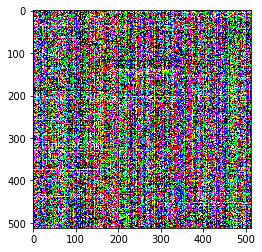

In [217]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block5_conv3').get_weights()[0][0].reshape(512,512,3))

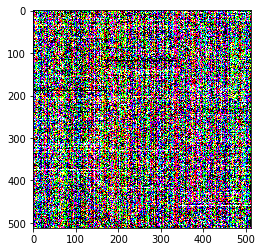

In [218]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block5_conv3').get_weights()[0][1].reshape(512,512,3))

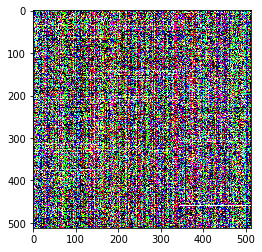

In [219]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block5_conv3').get_weights()[0][2].reshape(512,512,3))

- Last layer of 4th block

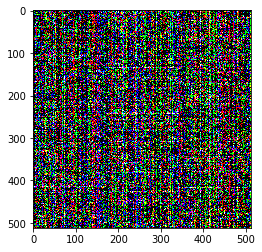

In [222]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block4_conv3').get_weights()[0][1].reshape(512,512,3))

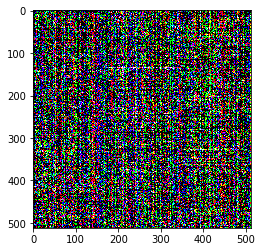

In [223]:
plt.imshow(model_bottleneck_last_cnn.get_layer('block4_conv3').get_weights()[0][2].reshape(512,512,3))

# Test the inception framework

In [276]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

In [277]:
xception_model = Xception(weights='imagenet')

In [278]:
xception_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

In [36]:
#base_model = InceptionV3(weights='imagenet', include_top=False)
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

### Change the last layer for three classes, and unfreeze the last two blocks

In [309]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_xception_finetune = model

0 input_11
1 conv2d_625
2 batch_normalization_624
3 activation_620
4 conv2d_626
5 batch_normalization_625
6 activation_621
7 conv2d_627
8 batch_normalization_626
9 activation_622
10 max_pooling2d_28
11 conv2d_628
12 batch_normalization_627
13 activation_623
14 conv2d_629
15 batch_normalization_628
16 activation_624
17 max_pooling2d_29
18 conv2d_633
19 batch_normalization_632
20 activation_628
21 conv2d_631
22 conv2d_634
23 batch_normalization_630
24 batch_normalization_633
25 activation_626
26 activation_629
27 average_pooling2d_60
28 conv2d_630
29 conv2d_632
30 conv2d_635
31 conv2d_636
32 batch_normalization_629
33 batch_normalization_631
34 batch_normalization_634
35 batch_normalization_635
36 activation_625
37 activation_627
38 activation_630
39 activation_631
40 mixed0
41 conv2d_640
42 batch_normalization_639
43 activation_635
44 conv2d_638
45 conv2d_641
46 batch_normalization_637
47 batch_normalization_640
48 activation_633
49 activation_636
50 average_pooling2d_61
51 conv2d_637
5

In [295]:
model_xception_finetune.compile(loss='binary_crossentropy', metrics =['accuracy'],optimizer='adam')

### Data generator with new target size for inception

In [49]:
train_datagen_xception = ImageDataGenerator(
                                   rotation_range=90,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                    vertical_flip=True,
                                   fill_mode='nearest')
train_generator_xception = train_datagen_xception.flow_from_directory(directory='data/train',
                                                    target_size=[229, 229],
                                                    batch_size=16,
                                                   classes=['type_1','type_2','type_3'])
validation_datagen_xception = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_generator_xception = validation_datagen_xception.flow_from_directory(directory='data/validation/',
                                                              target_size=[229, 229],
                                                              batch_size=16,
                                                             classes=['type_1','type_2','type_3'])

Found 678 images belonging to 3 classes.
Found 353 images belonging to 3 classes.


##### Visualize some images

In [52]:
x,y = next(train_generator_xception)

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

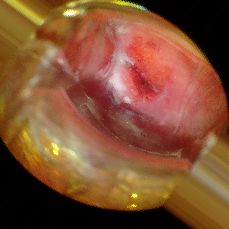

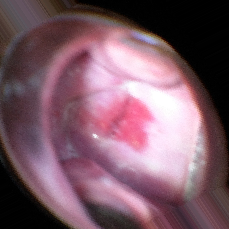

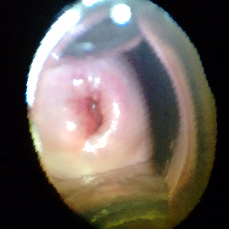

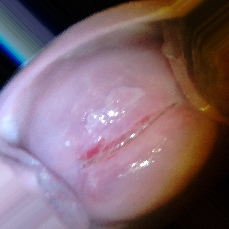

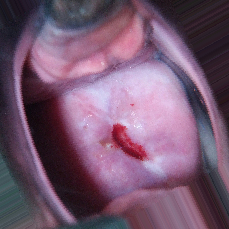

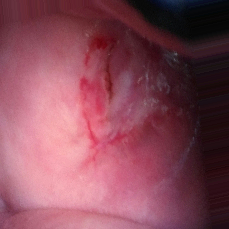

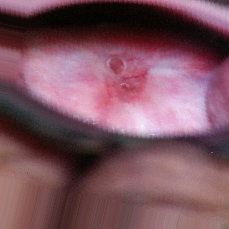

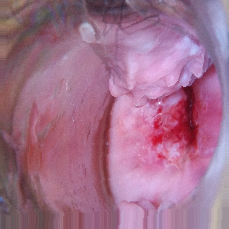

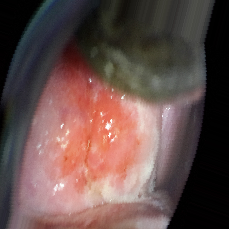

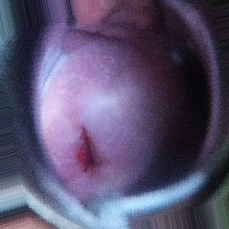

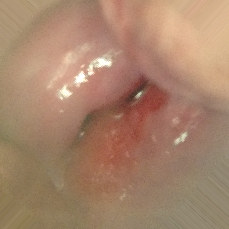

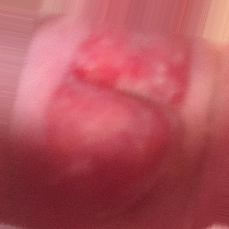

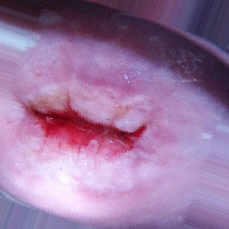

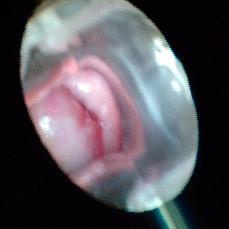

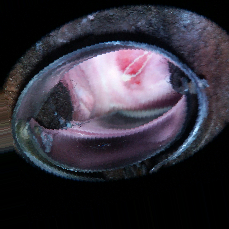

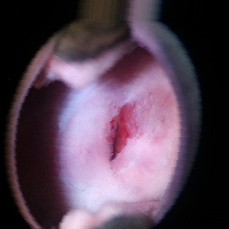

In [62]:
for i in x:
    display(array_to_img( i))

## After training for two days, with only 60% validation accuracy, test the model (last two blocks unfrozen)
- accuracy peaked at 65% for validation set during training while training accuracy around 95%

In [42]:
xception_model_prediction = inception_all()


0 input_5
1 conv2d_377
2 batch_normalization_377
3 activation_377
4 conv2d_378
5 batch_normalization_378
6 activation_378
7 conv2d_379
8 batch_normalization_379
9 activation_379
10 max_pooling2d_17
11 conv2d_380
12 batch_normalization_380
13 activation_380
14 conv2d_381
15 batch_normalization_381
16 activation_381
17 max_pooling2d_18
18 conv2d_385
19 batch_normalization_385
20 activation_385
21 conv2d_383
22 conv2d_386
23 batch_normalization_383
24 batch_normalization_386
25 activation_383
26 activation_386
27 average_pooling2d_37
28 conv2d_382
29 conv2d_384
30 conv2d_387
31 conv2d_388
32 batch_normalization_382
33 batch_normalization_384
34 batch_normalization_387
35 batch_normalization_388
36 activation_382
37 activation_384
38 activation_387
39 activation_388
40 mixed0
41 conv2d_392
42 batch_normalization_392
43 activation_392
44 conv2d_390
45 conv2d_393
46 batch_normalization_390
47 batch_normalization_393
48 activation_390
49 activation_393
50 average_pooling2d_38
51 conv2d_389
52

In [43]:
xception_model_prediction.load_weights('weights/inception_sgd_last_two.h5')

In [44]:
rootdir = '../kaggle - Cervical Cancer Screening/data/test'
test_images_pd = pd.DataFrame()
all_test_images = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        full_path = os.path.join(subdir, file)
        all_test_images.append(full_path)

In [45]:
row = []
with open('inception_last_two_predictions.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',')
    spamwriter.writerow(['image_name','Type_1','Type_2','Type_3'])
    for idx,image in enumerate(all_test_images):
        name = image.split('/')[-1]

        img = Image.open(image)
        img = img.resize((224,224), PIL.Image.ANTIALIAS)
        img = np.array(img).reshape(1,224,224,3)
        prediction = xception_model_prediction.predict(img)
        if idx %50 ==0:
            print(idx, 'image number of out 513')
        spamwriter.writerow([name,prediction[0][0],prediction[0][1],prediction[0][2]])

[[  1.50819302e-01   8.49130273e-01   5.04601267e-05]]
[[ 0.15001485  0.28451979  0.56546533]]
[[  1.07788011e-01   8.92211974e-01   2.47179219e-08]]
[[  4.40175738e-03   9.95598257e-01   3.75618514e-09]]
[[ 0.17053434  0.82725215  0.00221353]]
[[  7.36331195e-02   9.26366925e-01   4.12528394e-08]]
[[ 0.01465851  0.00348932  0.98185217]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonat

[[  2.33835001e-02   3.83950886e-04   9.76232529e-01]]
[[  5.16495621e-03   4.69606835e-04   9.94365454e-01]]
[[  1.98736995e-01   8.00668597e-01   5.94418496e-04]]
[[  6.57438338e-02   9.34187770e-01   6.83961844e-05]]
[[  2.11864132e-02   3.80396290e-04   9.78433251e-01]]
[[ 0.02831569  0.00378722  0.96789706]]
[[  1.57499965e-03   2.62686881e-05   9.98398721e-01]]
[[  4.87508446e-01   5.12476385e-01   1.50693477e-05]]
[[ 0.09267449  0.03348096  0.87384456]]
[[ 0.03681674  0.03506792  0.92811531]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 611057664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12666. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.08761647  0.06446956  0.84791398]]
[[ 0.26634943  0.72077066  0.01287986]]
[[  9.09936726e-02   9.08910751e-01   9.55928190e-05]]
[[ 0.03910192  0.00939195  0.95150608]]
[[  1.60854280e-01   8.39129388e-01   1.63289387e-05]]
[[ 0.17690653  0.02777046  0.79532301]]
[[ 0.3030735   0.044847    0.65207946]]
[[  5.84276812e-03   5.23752824e-04   9.93633509e-01]]
[[  7.02925026e-03   9.92970765e-01   4.79598006e-09]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 680591360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13727. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.1270711   0.87165046  0.00127841]]
[[  2.12416868e-03   2.27825039e-05   9.97853041e-01]]
[[  3.00670236e-01   6.99301779e-01   2.80135137e-05]]
[[  1.25370910e-02   3.79852776e-04   9.87083077e-01]]
[[  4.24275408e-04   9.26120356e-06   9.99566495e-01]]
[[ 0.29123932  0.70677358  0.00198713]]
[[ 0.13370308  0.86042488  0.0058721 ]]
[[  2.30109729e-02   9.76988971e-01   1.71181355e-07]]
[[  1.43179238e-01   8.56820166e-01   6.08940127e-07]]
[[ 0.04695284  0.006714    0.94633311]]
[[  1.38177365e-01   8.61742318e-01   8.03265793e-05]]
[[ 0.40056634  0.04280627  0.55662739]]
[[ 0.27510247  0.13158289  0.59331465]]
[[ 0.0090217   0.00117106  0.98980719]]
[[  1.90613477e-03   9.98093903e-01   1.42422489e-11]]
[[ 0.1073609   0.89104599  0.00159305]]
[[  7.36353174e-02   9.26359713e-01   4.98482359e-06]]
[[  5.84712811e-02   9.41436410e-01   9.22046456e-05]]
[[ 0.05646379  0.01269369  0.93084258]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 559480832 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 11879. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.318066    0.6811828   0.00075123]]
[[ 0.09728648  0.90163809  0.00107551]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204865536 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205389824 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 558563328 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11665. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.23227131  0.65270525  0.11502339]]
[[ 0.02562493  0.01289696  0.96147811]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 594411520 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12212. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  9.99851823e-01   1.47291546e-04   8.17364423e-07]]
[[ 0.01687698  0.00201602  0.981107  ]]
[[  4.34274018e-01   5.65723300e-01   2.64858113e-06]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 750845952 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14799. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.14685474  0.08719983  0.76594537]]
[[  1.32511228e-01   8.67447019e-01   4.17703886e-05]]
[[ 0.14994818  0.75998968  0.09006215]]
[[  2.41238251e-01   7.58761048e-01   7.32175522e-07]]
[[  9.49169159e-01   5.08269519e-02   3.84271243e-06]]
[[ 0.16320314  0.3455978   0.49119911]]
[[ 0.87145132  0.1206487   0.00789994]]
[[ 0.06078874  0.02129217  0.91791904]]
[[  3.87613066e-02   9.61209059e-01   2.96977669e-05]]
[[  1.65088999e-03   1.29888955e-04   9.98219192e-01]]
[[  9.99928474e-01   6.37048943e-05   7.83800715e-06]]
[[  3.83801805e-03   9.96161938e-01   3.13582168e-14]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 497156096 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10928. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  7.47174248e-02   9.25039530e-01   2.42996437e-04]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 716505088 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14275. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  3.19571085e-02   9.68042910e-01   8.62424887e-09]]
[[ 0.30491868  0.51093602  0.18414535]]
[[  1.74607933e-01   8.25304508e-01   8.75394035e-05]]
[[  1.07790709e-01   8.92191768e-01   1.75749992e-05]]
[[  1.95748031e-01   8.04251730e-01   1.72774520e-07]]
[[ 0.29207566  0.61885482  0.08906954]]
[[  3.55832018e-02   9.64404047e-01   1.27860694e-05]]
[[ 0.21686146  0.5550518   0.22808678]]
[[ 0.0506808   0.00277677  0.94654238]]
[[  9.99893904e-01   1.01840014e-04   4.27403393e-06]]
[[ 0.95145971  0.04632555  0.00221482]]
[[  1.32321622e-02   9.86767709e-01   1.59061599e-07]]
[[  2.19533622e-01   7.80321717e-01   1.44748963e-04]]
[[ 0.46065193  0.50511408  0.03423392]]
[[  2.47339204e-01   7.52660811e-01   1.85193928e-14]]
[[ 0.3292143   0.6330083   0.03777745]]
[[ 0.16914742  0.29882172  0.53203094]]
[[  1.38130352e-01   8.61549437e-01   3.20213701e-04]]
[[ 0.13042332  0.06562836  0.8039484 ]]
[[ 0.3714923   0.53437763  0.09412999]]
[[  3.24550853e-03   3.56169039e-05   9.96718824e-

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499122176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10758. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.21628946  0.78097111  0.00273945]]
[[ 0.04229983  0.01683185  0.94086832]]
[[ 0.63193971  0.11869577  0.24936448]]
[[ 0.36182246  0.14973518  0.48844233]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 565903360 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11777. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.26531389  0.68612826  0.04855792]]
[[ 0.32718724  0.63013077  0.04268204]]
[[ 0.06476177  0.07635637  0.85888183]]
[[ 0.20816416  0.78709584  0.00473998]]
[[  5.13049886e-02   3.20622290e-04   9.48374450e-01]]
[[ 0.79824108  0.17588505  0.02587388]]
[[ 0.18823802  0.69072574  0.12103624]]
[[ 0.28332752  0.229909    0.48676348]]
[[ 0.46037057  0.46769786  0.07193164]]
[[ 0.69212049  0.19354339  0.11433619]]
[[ 0.06218255  0.01676929  0.92104816]]
[[  1.53265074e-01   8.46585751e-01   1.49185697e-04]]
[[ 0.00962947  0.00239232  0.98797822]]
[[ 0.23582597  0.14940758  0.61476642]]
[[ 0.99486428  0.0010199   0.00411574]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 668860416 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13548. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  4.02615871e-03   4.21733246e-04   9.95552123e-01]]
[[  1.55740127e-01   8.44158888e-01   1.00944548e-04]]
[[ 0.9448598   0.03942057  0.01571966]]
[[ 0.98295045  0.00203255  0.01501705]]
[[ 0.1708279   0.57236296  0.25680912]]
[[  2.04099640e-02   7.61567149e-04   9.78828490e-01]]
[[ 0.16043378  0.82560027  0.01396596]]
[[  1.00000000e+00   9.85710003e-09   2.52156098e-13]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 566886400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11792. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  5.88874109e-02   9.41105187e-01   7.37860501e-06]]
[[  1.59458839e-03   9.98405397e-01   2.37468925e-08]]
[[ 0.87751573  0.12047362  0.00201065]]
[[ 0.13478653  0.0207804   0.84443307]]
[[ 0.04369158  0.02319022  0.93311822]]
[[ 0.24069422  0.04049471  0.71881109]]
[[ 0.70567667  0.15479508  0.1395282 ]]
[[ 0.03561609  0.01347926  0.95090467]]
[[ 0.21938768  0.21428129  0.56633097]]
[[ 0.11038921  0.06554461  0.82406616]]
[[  1.62130594e-02   9.83783066e-01   3.88469289e-06]]
[[  2.41061285e-01   7.58634806e-01   3.03911627e-04]]
[[ 0.71173823  0.27774665  0.0105151 ]]
[[ 0.26012093  0.73721915  0.00266   ]]
[[ 0.19954835  0.08834866  0.71210301]]
[[  6.07650399e-01   3.92295569e-01   5.40120491e-05]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 654901248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  9.97387826e-01   2.11560680e-03   4.96640219e-04]]
[[  9.28860679e-02   9.07113969e-01   4.90732859e-08]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 513671168 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10980. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  3.06116551e-01   6.93872571e-01   1.08151189e-05]]
[[  4.92851920e-02   9.50014174e-01   7.00660166e-04]]
[[ 0.98024231  0.01861382  0.00114386]]
[[ 0.09037819  0.89882123  0.01080057]]
[[  9.92157087e-02   9.00683224e-01   1.01028745e-04]]
[[ 0.02046483  0.00375464  0.97578055]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 671154176 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13583. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.05683764  0.01435061  0.92881179]]
[[ 0.07749438  0.01020281  0.91230279]]
[[ 0.07600567  0.05406034  0.86993396]]
[[ 0.29607117  0.30588612  0.39804268]]
[[ 0.01839343  0.00148644  0.98012012]]
[[  2.23270044e-01   7.76395679e-01   3.34324926e-04]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 542310400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11417. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  2.93168845e-03   9.97068346e-01   5.79176174e-08]]
[[ 0.29310778  0.61648577  0.09040647]]
[[ 0.2525928   0.69469458  0.05271267]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 896663552 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 16824. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.26495314  0.66829646  0.06675041]]
[[ 0.65258968  0.03909009  0.30832031]]
[[  9.97419715e-01   1.67204894e-03   9.08255752e-04]]
[[  9.48230803e-01   5.17689511e-02   2.01509849e-07]]
[[ 0.57679683  0.18490499  0.23829812]]
[[  1.84084967e-01   8.15915048e-01   2.34856774e-08]]
[[ 0.15064929  0.12079669  0.72855407]]
[[  3.74859571e-02   9.61583555e-01   9.30481357e-04]]
[[  5.06122550e-03   1.96345165e-04   9.94742393e-01]]
[[  3.56924185e-03   9.96430755e-01   3.33010746e-13]]
[[  9.95770395e-01   3.38709168e-03   8.42496462e-04]]
[[ 0.27777603  0.71391279  0.00831121]]
[[ 0.35894892  0.01929527  0.62175578]]
[[  9.10562277e-02   9.08818543e-01   1.25287945e-04]]
[[  9.96424258e-01   3.57529987e-03   4.59810991e-07]]
[[ 0.01230521  0.00151865  0.98617607]]
[[  9.95424688e-01   4.55084117e-03   2.44305029e-05]]
[[  1.23940986e-02   9.87575233e-01   3.07252849e-05]]
[[ 0.55686522  0.00076935  0.44236541]]
[[ 0.05555336  0.00871014  0.93573648]]
[[ 0.24278112  0.16686447  0.590354

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 457703424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10126. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  4.86838864e-03   1.06952517e-04   9.95024621e-01]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 467402752 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10474. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  4.02367301e-02   9.59762573e-01   6.85406462e-07]]
[[ 0.0964276   0.69648051  0.20709185]]
[[ 0.57097208  0.25634432  0.17268357]]
[[ 0.20830154  0.03176063  0.75993776]]
[[ 0.01266495  0.00213426  0.98520076]]
[[  8.19050193e-01   1.80918634e-01   3.11129043e-05]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 471859200 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10342. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.64303744  0.23148699  0.12547556]]
[[ 0.41526586  0.23267449  0.35205957]]
[[  7.59274781e-01   2.40719020e-01   6.27429927e-06]]
[[ 0.15110761  0.84664035  0.00225208]]
[[  6.90406607e-03   5.26098651e-04   9.92569864e-01]]
[[  1.18140122e-02   9.88178074e-01   7.85664906e-06]]
[[  1.76821940e-03   1.42104867e-07   9.98231709e-01]]
[[  7.95811176e-01   2.04188824e-01   4.03335250e-08]]
[[  2.57900596e-01   7.41386473e-01   7.12889479e-04]]
[[  1.91327363e-01   8.08512866e-01   1.59828953e-04]]
[[  2.55706944e-02   9.74403203e-01   2.60962188e-05]]
[[ 0.04133159  0.03010246  0.92856592]]
[[  1.23324757e-03   1.36812173e-06   9.98765349e-01]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 627507200 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 12917. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25880427512 bytes but only got 0. Skipping tag 20602
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178651468 bytes but only got 0. Skipping tag 20656
  "Skipping tag %s" % (size, len(dat

[[  2.12554689e-02   9.78726029e-01   1.85299177e-05]]
[[ 0.79738885  0.09510711  0.10750407]]
[[  2.83479393e-01   7.16519058e-01   1.50562175e-06]]
[[  1.04631074e-02   1.35725022e-05   9.89523351e-01]]
[[ 0.05310207  0.00892016  0.93797773]]
[[  3.63319755e-01   6.36050820e-01   6.29398797e-04]]
[[  6.65594786e-02   9.33310807e-01   1.29772001e-04]]
[[ 0.24330834  0.30045524  0.45623645]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 454950912 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 10284. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.29407823  0.67923546  0.02668629]]
[[  3.50317894e-03   9.96496856e-01   5.50013268e-13]]
[[ 0.06660113  0.87422603  0.05917282]]
[[ 0.54349446  0.30508325  0.15142226]]
[[  1.34658245e-02   9.48348024e-04   9.85585868e-01]]
[[  6.46045955e-04   1.90831161e-05   9.99334872e-01]]
[[  3.55330765e-01   6.44619823e-01   4.93856969e-05]]
[[ 0.31500477  0.57905287  0.10594235]]
[[ 0.04093358  0.02620658  0.93285984]]
[[  4.71355580e-03   2.01499206e-04   9.95084941e-01]]
[[ 0.99441999  0.00287964  0.00270037]]
[[ 0.04082622  0.95820725  0.00096659]]
[[ 0.10278301  0.06102202  0.83619499]]
[[  1.48828343e-01   8.51171613e-01   4.79254449e-11]]
[[  5.17368689e-02   2.13343701e-05   9.48241830e-01]]
[[  8.36263180e-01   1.63683757e-01   5.30053621e-05]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 715718656 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 14263. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.65576589  0.12575538  0.21847868]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 499187712 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10759. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.14614122e-01   8.85328114e-01   5.77538449e-05]]
[[  8.17067176e-02   9.18215632e-01   7.76387096e-05]]
[[ 0.28500804  0.670151    0.04484096]]
[[ 0.75639874  0.07371023  0.16989097]]
[[  7.06495568e-02   9.29350317e-01   8.15668528e-08]]
[[ 0.06124074  0.9355005   0.00325878]]
[[  9.83423471e-01   1.65577643e-02   1.87122005e-05]]
[[ 0.35598475  0.64071023  0.00330509]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 527171584 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11186. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.02643045e-02   9.89735723e-01   2.80854420e-12]]
[[  1.32565098e-02   9.86740530e-01   2.97915813e-06]]
[[  9.35882509e-01   6.41149655e-02   2.58132241e-06]]
[[ 0.89677346  0.09771898  0.00550757]]
[[  2.01019887e-02   9.79898036e-01   8.15659540e-10]]
[[ 0.3381834   0.50244826  0.15936826]]
[[  1.88351341e-03   7.65346340e-05   9.98040020e-01]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 518914048 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11060. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  6.91916525e-01   3.07932317e-01   1.51140543e-04]]
[[ 0.22792728  0.59962922  0.17244349]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 653459456 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13113. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.21289358e-01   8.78552556e-01   1.58032854e-04]]
[[ 0.1096093   0.030412    0.85997868]]
[[  9.60853416e-03   2.22835479e-05   9.90369141e-01]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 541589504 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11406. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  6.94341660e-01   3.05286050e-01   3.72312876e-04]]
[[  4.13585571e-04   5.46468436e-06   9.99580920e-01]]
[[ 0.21957245  0.70238125  0.07804637]]
[[ 0.59617966  0.40232068  0.00149966]]
[[  7.58156329e-02   9.24179077e-01   5.31513388e-06]]
[[ 0.96869636  0.02246273  0.00884094]]
[[  5.12833782e-02   9.48716581e-01   6.27572927e-09]]
[[  8.37983936e-03   9.91610229e-01   9.88066859e-06]]
[[ 0.4032411   0.1574641   0.43929487]]
[[ 0.08234674  0.9032132   0.01444006]]
[[ 0.38211218  0.54956919  0.06831864]]
[[ 0.2160971   0.21989088  0.56401199]]
[[ 0.07465887  0.92144644  0.00389468]]
[[ 0.35653457  0.60672456  0.03674095]]
[[ 0.13528877  0.01468093  0.8500303 ]]
[[  3.49682616e-03   5.16377149e-05   9.96451497e-01]]
[[ 0.13920142  0.83770978  0.02308878]]
[[ 0.08805572  0.0229094   0.88903493]]
[[ 0.32730323  0.66507483  0.00762193]]
[[ 0.1940922   0.75919777  0.04670999]]
[[ 0.46236694  0.53678763  0.00084551]]
[[  9.98496294e-01   1.49827858e-03   5.44918430e-06]]
[[  8.71078447e

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 510197760 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10927. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  9.99984860e-01   1.41570690e-05   9.69764869e-07]]
[[ 0.18001544  0.68771255  0.13227192]]
[[  8.19112286e-02   9.18087006e-01   1.80457403e-06]]
[[  3.21869249e-03   7.08683583e-05   9.96710420e-01]]
[[ 0.02916553  0.0079321   0.96290237]]
[[  2.06781492e-01   7.93213069e-01   5.47077934e-06]]
[[ 0.53598529  0.46081039  0.00320422]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 760020992 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14739. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 372937384 bytes but only got 0. Skipping tag 39948
  "Skipping tag %s" % (size, len(data), tag))


[[  1.98008539e-03   6.07383117e-05   9.97959137e-01]]
[[ 0.01589052  0.00191826  0.98219115]]
[[  6.26624763e-01   3.73375177e-01   4.70453223e-08]]
[[ 0.63216758  0.36697069  0.00086176]]
[[  1.51295140e-01   8.48694861e-01   9.98192172e-06]]
[[  2.23352388e-02   9.77633536e-01   3.12658231e-05]]
[[ 0.17531617  0.41209039  0.41259339]]
[[  1.70075987e-02   9.82977748e-01   1.46934353e-05]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 445775872 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9944. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.05514786  0.92588371  0.01896838]]
[[ 0.20677675  0.15113142  0.64209181]]
[[ 0.53664017  0.25663409  0.20672573]]
[[  3.77637073e-02   9.62232351e-01   3.84994564e-06]]
[[  5.92716206e-05   4.21269817e-07   9.99940276e-01]]
[[  9.74378407e-01   2.56175119e-02   4.06160916e-06]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 592576512 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12184. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  9.98520315e-01   1.47966726e-03   2.48578658e-10]]
[[  1.00000000e+00   1.13791016e-13   1.90325273e-11]]
[[ 0.1305394   0.86177975  0.00768084]]
[[ 0.04421739  0.95396137  0.00182125]]
[[  2.89411168e-03   2.23173429e-05   9.97083604e-01]]
[[ 0.27900776  0.71965218  0.0013401 ]]
[[  3.59994243e-03   9.96399999e-01   9.77726927e-11]]
[[ 0.42731488  0.51369792  0.0589872 ]]
[[ 0.06164107  0.92397743  0.01438157]]
[[ 0.40863353  0.58744621  0.00392027]]
[[ 0.04797805  0.01807651  0.93394542]]
[[ 0.36219528  0.59804457  0.03976018]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 458293248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10135. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.94530094  0.01754708  0.037152  ]]
[[  9.46867943e-01   5.31320311e-02   1.10048699e-08]]
[[ 0.56983942  0.0117275   0.41843313]]
[[ 0.09890579  0.77426726  0.12682702]]
[[  8.99861693e-01   1.00137308e-01   9.43638724e-07]]
[[ 0.16996911  0.82545501  0.00457591]]
[[  7.81343102e-01   2.18586802e-01   7.01305689e-05]]
[[ 0.09311609  0.01291403  0.89396983]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 615579648 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12535. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.95598722e-01   8.04401219e-01   1.27655213e-07]]
[[ 0.5181672   0.14937873  0.33245406]]
[[ 0.64523035  0.35373291  0.00103679]]
[[  6.07750798e-03   4.40404547e-05   9.93878424e-01]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 550502400 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11542. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  7.54178092e-02   9.24581707e-01   4.59749288e-07]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 411828224 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9426. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.07972119  0.91708004  0.00319887]]
[[ 0.25526941  0.57981181  0.16491878]]
[[ 0.19060719  0.65744835  0.15194447]]
[[  6.22536987e-02   9.37737763e-01   8.58677231e-06]]
[[ 0.1630995   0.24033953  0.59656096]]
[[  9.99996185e-01   1.58921239e-06   2.29883608e-06]]
[[ 0.27413806  0.71850574  0.00735619]]
[[  2.35008122e-03   1.05153209e-04   9.97544706e-01]]
[[ 0.19377233  0.79170531  0.01452229]]
[[ 0.01602461  0.00276671  0.98120868]]
[[ 0.04836171  0.02290529  0.92873299]]
[[ 0.0640713   0.00878402  0.92714471]]
[[  1.22704200e-01   8.77295017e-01   8.05549405e-07]]
[[  3.82732362e-01   6.16860509e-01   4.07072570e-04]]
[[  1.19790817e-02   9.88019884e-01   1.09428811e-06]]
[[  6.19589835e-02   2.17901528e-04   9.37823057e-01]]
[[  4.19985235e-01   5.79989314e-01   2.53402941e-05]]
[[ 0.04486828  0.0021432   0.95298851]]
[[  2.94968747e-02   9.70482707e-01   2.03494237e-05]]
[[  3.48204486e-02   9.65178967e-01   5.70257669e-07]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 572391424 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11876. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.11418397  0.88264436  0.0031716 ]]
[[  3.00990492e-01   6.98396146e-01   6.13359211e-04]]
[[ 0.02803866  0.00336733  0.96859401]]
[[ 0.28340232  0.06100002  0.65559763]]
[[ 0.14781065  0.30428234  0.54790705]]
[[ 0.03943289  0.01184569  0.94872141]]
[[ 0.6998601   0.00364704  0.29649282]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 670171136 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 219021312 bytes but only got 13568. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.03325665  0.00396808  0.96277529]]
[[  2.84183085e-01   7.15783477e-01   3.34883480e-05]]
[[  9.98171091e-01   4.16388764e-04   1.41256198e-03]]
[[  8.17878723e-01   1.82018727e-01   1.02529790e-04]]
[[  5.46186626e-01   4.53726023e-01   8.73686367e-05]]
[[  6.16132259e-01   3.83845747e-01   2.19632566e-05]]
[[  4.68173653e-01   5.31567693e-01   2.58588989e-04]]
[[ 0.22072664  0.76702124  0.01225217]]
[[ 0.18642758  0.26906252  0.54450995]]
[[ 0.41566527  0.50019854  0.0841362 ]]
[[  4.36476134e-02   3.17925587e-04   9.56034482e-01]]
[[  8.49002507e-03   9.91509795e-01   2.18808623e-07]]
[[  5.35695441e-03   6.28958805e-04   9.94014084e-01]]
[[ 0.07813727  0.06434218  0.85752052]]
[[  1.68538955e-03   4.71022249e-05   9.98267531e-01]]
[[  9.78122115e-01   2.15520803e-02   3.25776171e-04]]
[[  9.99932051e-01   6.42183004e-05   3.71362830e-06]]
[[ 0.05818412  0.01483223  0.92698365]]
[[ 0.08912751  0.89659333  0.01427919]]
[[  2.14289352e-01   7.85539687e-01   1.70930871e-04]]
[[  8

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 599064576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12283. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.89069763e-01   8.10927451e-01   2.76807464e-06]]
[[  3.12709453e-04   1.79901156e-06   9.99685526e-01]]
[[  9.99153733e-01   8.44012131e-04   2.24199766e-06]]
[[ 0.25252733  0.00598809  0.74148458]]
[[  6.47737994e-04   9.99352276e-01   2.61500934e-12]]
[[ 0.08854139  0.01604895  0.8954097 ]]
[[ 0.07500819  0.92208081  0.00291101]]
[[ 0.07061099  0.01321969  0.91616935]]
[[ 0.13271441  0.86317426  0.0041113 ]]
[[  1.06862135e-01   8.93017292e-01   1.20657794e-04]]
[[  1.43064544e-01   8.56607556e-01   3.27914138e-04]]
[[ 0.37024456  0.5959745   0.03378095]]
[[  9.99037027e-01   1.85113255e-04   7.77869369e-04]]
[[ 0.12875783  0.06678341  0.80445874]]
[[  5.75581286e-03   9.94243681e-01   4.41921799e-07]]
[[ 0.44307131  0.44713283  0.10979593]]
[[ 0.18243533  0.81582654  0.00173814]]
[[  1.83831714e-02   9.81610894e-01   5.97838653e-06]]
[[ 0.15374869  0.20530771  0.64094359]]
[[ 0.11876864  0.00932859  0.87190276]]
[[  6.00521103e-04   2.15480231e-05   9.99377847e-01]]
[[  7.0503

/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 539426816 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11373. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.51371926e-01   8.48595798e-01   3.22240230e-05]]
[[ 0.84726685  0.1357833   0.01694983]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 602996736 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12343. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.30919978e-01   8.68510008e-01   5.70087577e-04]]
[[  4.61374432e-01   5.38527071e-01   9.84765793e-05]]
[[  9.16781947e-02   9.08316910e-01   4.92474874e-06]]
[[ 0.9376626   0.06117097  0.00116636]]
[[ 0.49224091  0.35633302  0.15142615]]
[[ 0.09476952  0.89552075  0.00970969]]
[[ 0.08247479  0.03356724  0.88395792]]
[[  4.05643940e-01   5.94333529e-01   2.25681652e-05]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 421462016 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 9573. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  4.60656770e-02   9.53820586e-01   1.13708622e-04]]
[[ 0.61729032  0.36305487  0.01965478]]
[[  9.99117553e-01   6.56358316e-04   2.26098986e-04]]
[[  5.14392555e-01   4.85585183e-01   2.22126000e-05]]
[[ 0.19868626  0.46711192  0.33420181]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 531562496 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11253. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  6.71104640e-02   9.32889342e-01   1.77056492e-07]]
[[  9.53426182e-01   1.96523775e-04   4.63772602e-02]]
[[  4.47883397e-01   5.52116513e-01   3.36808736e-09]]
[[ 0.95236152  0.00316319  0.04447532]]
[[  2.80987862e-02   9.71897781e-01   3.50393202e-06]]
[[ 0.72783691  0.26737624  0.0047868 ]]
[[ 0.13043615  0.86449915  0.00506474]]
[[ 0.39805183  0.32285294  0.27909523]]
[[  9.44091499e-01   5.58748432e-02   3.36014491e-05]]
[[  5.72250174e-05   9.99942780e-01   2.51139255e-15]]
[[ 0.25140524  0.40270203  0.3458927 ]]
[[  8.36410746e-03   7.07228028e-04   9.90928710e-01]]
[[ 0.43594608  0.56332451  0.00072945]]
[[  8.10158381e-04   4.99722555e-05   9.99139786e-01]]
[[  1.42400488e-01   8.57598543e-01   8.83449673e-07]]
[[ 0.94695258  0.00123926  0.05180816]]
[[ 0.26330155  0.65396374  0.0827347 ]]
[[ 0.02424074  0.00153955  0.97421968]]
[[  2.08464079e-02   1.07407061e-04   9.79046226e-01]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 622264320 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12637. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  4.18371052e-01   5.81628799e-01   1.09386036e-07]]
[[ 0.20533298  0.25226611  0.5424009 ]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204996608 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205520896 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 670892032 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206045184 bytes but only got 13381. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.26098418  0.73194253  0.00707327]]
[[ 0.06224445  0.00849652  0.929259  ]]
[[  2.83789393e-02   9.71567273e-01   5.37549604e-05]]
[[ 0.1503955   0.03636283  0.81324166]]
[[  9.99962330e-01   3.45111366e-05   3.11966051e-06]]
[[ 0.49365702  0.49284676  0.01349618]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 605028352 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12374. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  4.39781211e-02   9.55302000e-01   7.19786738e-04]]
[[ 0.09299834  0.90569544  0.00130629]]
[[  1.02576390e-02   9.08292539e-04   9.88834083e-01]]
[[  7.32686510e-03   9.92672980e-01   1.36816695e-07]]
[[  1.00892456e-02   6.24061387e-04   9.89286661e-01]]
[[  7.49612867e-04   1.42687795e-05   9.99236107e-01]]
[[  2.00967580e-01   7.99028575e-01   3.78123718e-06]]
[[ 0.01632658  0.00263602  0.98103732]]
[[  8.54504287e-01   1.45298764e-01   1.96866764e-04]]
[[  6.84857011e-01   3.15142006e-01   9.89362775e-07]]
[[ 0.16596363  0.12483038  0.70920604]]
[[ 0.11074276  0.88503492  0.00422229]]
[[ 0.51661116  0.29702577  0.18636312]]
[[  1.04542673e-02   9.89545763e-01   4.92490271e-09]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 452460544 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10046. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.65019915e-01   8.34969282e-01   1.08238946e-05]]
[[ 0.27480844  0.71908379  0.00610775]]
[[ 0.15691036  0.82863182  0.01445785]]
[[  3.61640123e-03   9.96367812e-01   1.57668419e-05]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 647168000 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13017. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  9.99999881e-01   4.33961622e-09   1.52565747e-07]]
[[ 0.12135332  0.84833658  0.03031015]]
[[ 0.08839794  0.00276021  0.90884179]]
[[  1.96105447e-02   4.23292833e-04   9.79966104e-01]]
[[  6.42255589e-04   1.39382437e-05   9.99343812e-01]]
[[ 0.07487725  0.88205391  0.04306883]]
[[  2.41599511e-03   2.34615769e-07   9.97583747e-01]]
[[  1.51237482e-02   9.84875500e-01   8.29012890e-07]]
[[  9.83287454e-01   1.66370105e-02   7.55893852e-05]]
[[  3.86154396e-03   4.70014813e-04   9.95668411e-01]]
[[  9.73471344e-01   2.65254024e-02   3.28240253e-06]]
[[  4.93924366e-03   9.95060742e-01   5.56120124e-12]]
[[  6.56482160e-01   3.43451113e-01   6.66429187e-05]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 518586368 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11055. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 26527738112 bytes but only got 0. Skipping tag 19153
  "Skipping tag %s" % (size, len(data), tag))


[[  2.49712784e-02   9.75028634e-01   1.34980041e-07]]
[[  4.87633236e-03   1.59056799e-05   9.95107770e-01]]
[[ 0.39839965  0.53853047  0.06306981]]
[[ 0.19372788  0.79572278  0.01054936]]
[[ 0.91399223  0.06837642  0.01763133]]
[[ 0.16420753  0.52169704  0.31409544]]
[[  4.16272029e-04   1.14145851e-05   9.99572337e-01]]
[[  1.06492385e-01   8.93507242e-01   3.03170992e-07]]
[[  3.58013287e-02   9.64198589e-01   2.04377026e-09]]
[[  9.35973376e-02   9.06396091e-01   6.63419041e-06]]
[[ 0.17071196  0.8264631   0.00282496]]
[[ 0.46588469  0.43563196  0.09848337]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 537329664 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11341. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  1.61773451e-02   9.83822644e-01   8.78566819e-09]]
[[ 0.52855402  0.46234113  0.00910486]]
[[ 0.23028263  0.76852405  0.00119341]]
[[  2.10440066e-02   9.78955984e-01   2.12840197e-11]]
[[ 0.39559683  0.10525779  0.49914536]]
[[ 0.45963687  0.21989653  0.3204667 ]]
[[  6.80168916e-04   2.27634428e-05   9.99297023e-01]]
[[  9.90021378e-02   9.00996566e-01   1.24763085e-06]]
[[ 0.30626959  0.00738968  0.68634081]]
[[  8.14090252e-01   1.85841724e-01   6.80324301e-05]]
[[ 0.11226889  0.78486103  0.10287003]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 532021248 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11260. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[  9.99890447e-01   9.46803484e-05   1.49014122e-05]]
[[ 0.01401324  0.00150146  0.98448527]]
[[ 0.9964174   0.0014785   0.00210408]]
[[ 0.65227157  0.34593204  0.00179632]]
[[ 0.1228523   0.17769654  0.69945115]]
[[ 0.13778746  0.05362771  0.80858481]]


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 592379904 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12181. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))


[[ 0.20561609  0.76511949  0.02926445]]
[[ 0.12260455  0.11164264  0.76575285]]
[[ 0.0775236   0.0225821   0.89989436]]
[[ 0.39138848  0.59759599  0.01101555]]
[[ 0.99666256  0.00102918  0.00230829]]
[[ 0.0363781   0.01759465  0.94602722]]
[[  1.20142438e-01   8.79151642e-01   7.05946353e-04]]
[[  5.18355519e-03   9.94816482e-01   4.81189266e-09]]
[[  6.75795451e-02   9.32330668e-01   8.98080325e-05]]
[[  3.50451432e-02   9.64953244e-01   1.62182357e-06]]
[[ 0.86449999  0.02741605  0.10808391]]
[[ 0.52946925  0.37563902  0.0948917 ]]
[[ 0.22213829  0.22790226  0.54995948]]


# Test Inception with unfreezing the entire model
- Load the weights from imagenet, but train the model on all layers
- Also, preprocess the images to remove the means and divide by the standard deviation

In [37]:
def inception_all():
        # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(3, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



    # at this point, the top layers are well trained and we can start fine-tuning
    # convolutional layers from inception V3. We will freeze the bottom N layers
    # and train the remaining top layers.

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    for i, layer in enumerate(base_model.layers):
        print(i, layer.name)

    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 172 layers and unfreeze the rest:
    for layer in model.layers[:172]:
        layer.trainable = True
    for layer in model.layers[172:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    from keras.optimizers import SGD
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_xception_finetune = model
    return model

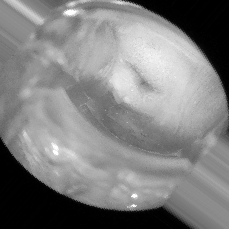

In [85]:
#first channel
array_to_img(x[0][:,:,0].reshape(229,229,1))

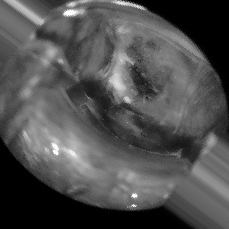

In [87]:
# second channel
array_to_img(x[0][:,:,1].reshape(229,229,1))

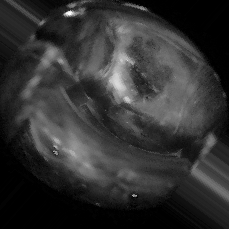

In [88]:
#third channel
array_to_img(x[0][:,:,2].reshape(229,229,1))

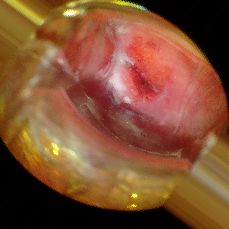

In [89]:
# original image
array_to_img(x[0])

In [157]:

def image_transformation(image):
    standardscaler = StandardScaler()

    new_image = np.zeros((image.shape))


    for i in range(3):
        new_image[:,:,i] = np.array([standardscaler.fit_transform(image[:,:,i])])



    return new_image


In [159]:
new_image= image_transformation(x[0])

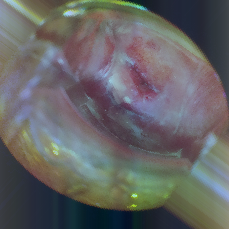

In [160]:
# remove the mean and divide by standard deviation
array_to_img(new_image)

In [151]:
train_datagen_xception = ImageDataGenerator(preprocessing_function=image_transformation,
                                   rotation_range=90,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                    vertical_flip=True,
                                   fill_mode='nearest')
train_generator_xception = train_datagen_xception.flow_from_directory(directory='data/train',
                                                    target_size=[229, 229],
                                                    batch_size=16,
                                                   classes=['type_1','type_2','type_3'])
validation_datagen_xception = ImageDataGenerator(preprocessing_function=image_transformation,rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_generator_xception = validation_datagen_xception.flow_from_directory(directory='data/validation/',
                                                              target_size=[229, 229],
                                                              batch_size=16,
                                                             classes=['type_1','type_2','type_3'])

Found 687 images belonging to 3 classes.
Found 344 images belonging to 3 classes.


In [152]:
model = inception_all()

0 input_6
1 conv2d_471
2 batch_normalization_471
3 activation_471
4 conv2d_472
5 batch_normalization_472
6 activation_472
7 conv2d_473
8 batch_normalization_473
9 activation_473
10 max_pooling2d_21
11 conv2d_474
12 batch_normalization_474
13 activation_474
14 conv2d_475
15 batch_normalization_475
16 activation_475
17 max_pooling2d_22
18 conv2d_479
19 batch_normalization_479
20 activation_479
21 conv2d_477
22 conv2d_480
23 batch_normalization_477
24 batch_normalization_480
25 activation_477
26 activation_480
27 average_pooling2d_46
28 conv2d_476
29 conv2d_478
30 conv2d_481
31 conv2d_482
32 batch_normalization_476
33 batch_normalization_478
34 batch_normalization_481
35 batch_normalization_482
36 activation_476
37 activation_478
38 activation_481
39 activation_482
40 mixed0
41 conv2d_486
42 batch_normalization_486
43 activation_486
44 conv2d_484
45 conv2d_487
46 batch_normalization_484
47 batch_normalization_487
48 activation_484
49 activation_487
50 average_pooling2d_47
51 conv2d_483
52

In [155]:
model.fit_generator(train_generator_xception, steps_per_epoch=1)

KeyboardInterrupt: 

In [170]:
# training so far

In [53]:
t = []
with open('all_layers_normalized_loss','r') as fp:
    t.append(fp.readlines())

In [54]:
training_loss = re.findall(
    r'[0123456789]{3}s - loss: [0123456789]{1}.[0123456789]{4}',str(t))

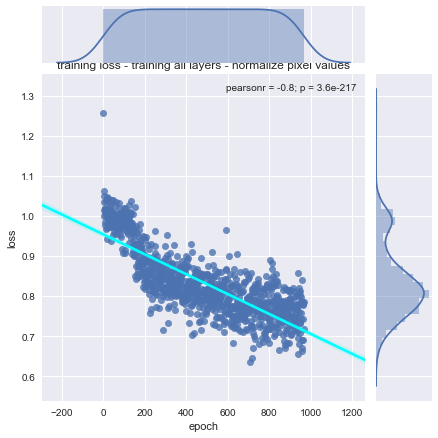

In [55]:

fig = sns.jointplot(np.array([_ for _ in range(len(training_loss))]),
            np.array([float(i.split(' ')[3]) for i in training_loss]),kind='reg',
           joint_kws={'line_kws':{'color':'cyan'}}, order=1)

plt.title('training loss - training all layers - normalize pixel values')
plt.xlabel('epoch')
plt.ylabel('loss')

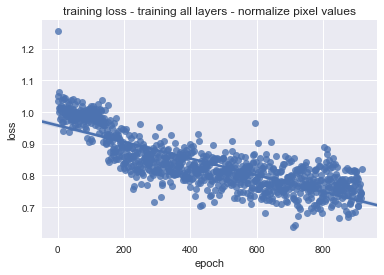

In [52]:
sns.regplot(np.array([_ for _ in range(len(training_loss))]),
            np.array([float(i.split(' ')[3]) for i in training_loss]),order=1)
plt.title('training loss - training all layers - normalize pixel values')
plt.xlabel('epoch')
plt.ylabel('loss')

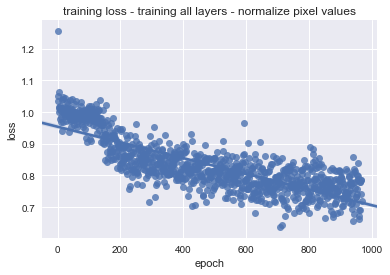

In [56]:
sns.regplot(np.array([_ for _ in range(len(training_loss))]),
            np.array([float(i.split(' ')[3]) for i in training_loss]),order=1)
plt.title('training loss - training all layers - normalize pixel values')
plt.xlabel('epoch')
plt.ylabel('loss')